## FACE RECOGNITION BASED ON EIGENFACES

Python script of the project for the course Data Mining and Neurocomputing. 

Authors:
- Jacopo Fantini 12109101

- Claudio Maffi 12111048

- Marta Salvi 12110437

## IMPORT LIBRARIES AND DATASET OVERVIEW

In [1]:
import pylab as pl
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from collections import Counter
import copy

This dataset is a dictionary-like object, with the following attributes.

data: numpy array of shape (13233, 2914).

Each row corresponds to a ravelled face image of original size 62 x 47 pixels. Changing the slice_ or resize parameters will change the shape of the output.

images: numpy array of shape (13233, 62, 47)
Each row is a face image corresponding to one of the 5749 people in the dataset. Changing the slice_ or resize parameters will change the shape of the output.

target: numpy array of shape (13233,)
Labels associated to each face image. Those labels range from 0-5748 and correspond to the person IDs.

DESCR: str
Description of the Labeled Faces in the Wild (LFW) dataset.

We download it through sklearn with resize=1 in order to have the best quality of the images and we take only who has more then 100 images of his face (the original ones correspond at a resize=0.5) .


In [2]:
df = fetch_lfw_people(min_faces_per_person=100, resize=1)

In [3]:
n_samples, h, w = df.images.shape
np.random.seed(42)

We take the data already flattened (df.data) instead of the images (data.images).

In [4]:
X = copy.copy(df.data) #already flattened
n_features = X.shape[1]

In [5]:
y = copy.copy(df.target) #target number used for classification 
target_names = copy.copy(df.target_names) #target names 
n_classes = target_names.shape[0]

In [6]:
print("Total dataset size:")
print("number of samples:", n_samples)
print("number of features:", n_features)
print("number of classes:", n_classes)
print("target names:", df.target_names)
print("number of samples for each class(name):",Counter(df.target))

Total dataset size:
number of samples: 1140
number of features: 11750
number of classes: 5
target names: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
number of samples for each class(name): Counter({2: 530, 0: 236, 4: 144, 1: 121, 3: 109})


The dataset is not balanced: there are 236 images of Powell, 121 of Rumsfeld, 530 of Bush, 109 of Schroeder and 144 of Blair. This has to be considered while training a classifier because the class imbalance may affect the performance of the classifier itself. 

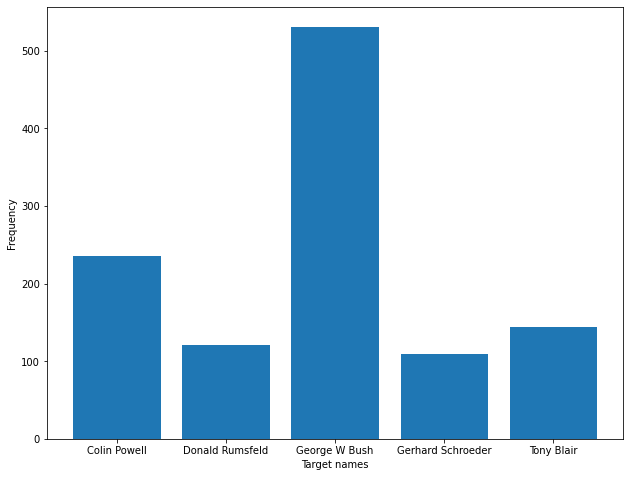

In [7]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Target names')
ax.set_ylabel('Frequency')
langs = ['Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Tony Blair'] 
c=[236,121,530,109,144]
ax.bar(langs,c)
plt.show()

The dataset is splitted in train and test sets with a percentage of 80% for the train and 20% for the test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## FEATURE EXTRACTION WITH PCA

Here we apply the PCA transformation to our images data already flattened; it has to be fitted first and then we can extract the eigenfaces from both the train and test sets.
With the option whiten=True, vectors are multiplied by the square root of n_samples and then divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.

In [9]:
n_components = 200
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

In [10]:
eigenfaces = pca.components_.reshape((n_components, h, w))


In order to improve the performance of our classifier we also normalize between 0 and 1 each pixel value before it's transformed dividing it by 255, that is the max value and 0 is the min value.

In [11]:
X_train_pca = pca.transform(X_train/255)
X_test_pca = pca.transform(X_test/255)

Here we can see the eigenfaces extracted with the PCA.

In [12]:
#function used to plot the following eigenfaces gallery 
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

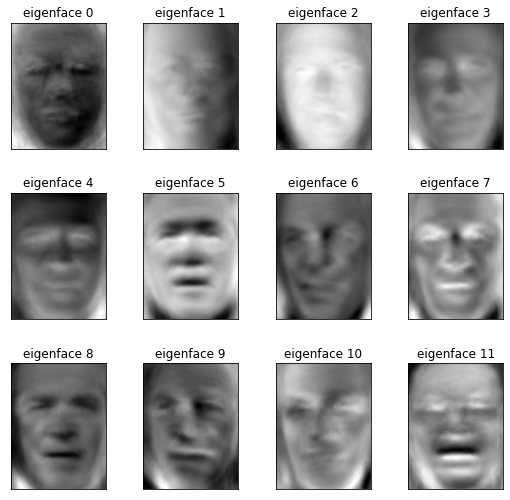

In [13]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## SVM 

Here we perform our first model that is an SVM with rbf as we found in the papers mentioned in our report. In order to find the best parameter to fine tune our SVM model we use the Grid Search techniques that allow us to train different models with all combination of parameter included in the param_grid dictionary here created. The Grid Search will give the model that achieve the best performance as output. 
We also add a cost matrix to the classifier with the option class_weight='balanced' because we have to deal with the class imbalance; in this way we add a weighted cost at each class error equal to 1 divided for the class frequencies in the input data. Otherwise the class 2 (corresponding to the images rapresenting Bush) may be always the most probable predicted class in the test set. 

In [14]:
print("Fitting the classifier to the training set")
param_grid = {
         'C': [10,1e2,1e3, 5e3, 1e4],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(svm.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01)


Train perfomance and cofusion matrix:

In [15]:
y_pred = svm.predict(X_train_pca)
print(classification_report(y_train, y_pred, target_names=target_names))
print(confusion_matrix(y_train, y_pred, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       0.92      0.95      0.94       186
  Donald Rumsfeld       0.91      0.93      0.92        96
    George W Bush       0.97      0.93      0.95       424
Gerhard Schroeder       0.90      0.95      0.93        87
       Tony Blair       0.93      0.95      0.94       119

         accuracy                           0.94       912
        macro avg       0.93      0.94      0.93       912
     weighted avg       0.94      0.94      0.94       912

[[177   0   4   0   5]
 [  2  89   5   0   0]
 [ 10   8 396   7   3]
 [  0   1   2  83   1]
 [  3   0   1   2 113]]


Test perfomance and cofusion matrix:

In [16]:
y_pred = svm.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       0.87      0.90      0.88        50
  Donald Rumsfeld       0.82      0.92      0.87        25
    George W Bush       0.94      0.89      0.91       106
Gerhard Schroeder       0.77      0.91      0.83        22
       Tony Blair       0.95      0.84      0.89        25

         accuracy                           0.89       228
        macro avg       0.87      0.89      0.88       228
     weighted avg       0.90      0.89      0.89       228

[[45  2  2  0  1]
 [ 0 23  1  1  0]
 [ 7  3 94  2  0]
 [ 0  0  2 20  0]
 [ 0  0  1  3 21]]


## 5-NN WITH EUCLIDIAN DISTANCE

Here we try to classify our eigenfaces with a Nearest Neighbors Classifier that used the euclidean distance as metric to compute the classes. This is also another classifier that is used in the papers we talk about in our report. As we did with the SVM classifier, here we use the Grid Search method to find the best parameters to decide to use the uniform or distance function used in prediction where in the uniform all points in each neighborhood are weighted equally while in the distance, closer neighbors of a query point will have a greater influence than neighbors which are further away. We set the leaf size at 30 because we have a strong overfitting but trying to tuning this parameters the accuracy on the train set doesn't decrease by 1. So we choose the leaf size that better perform on the test set. 

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
knn_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])
params = [{'knn__n_neighbors': [5],
         'knn__weights': [ 'uniform','distance'],
         'knn__leaf_size': [30]}]
gs_knn = GridSearchCV(knn_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs_knn.fit(X_train_pca, y_train)
gs_knn.best_params_

{'knn__leaf_size': 30, 'knn__n_neighbors': 5, 'knn__weights': 'distance'}

Training performance and confusion matrix:

In [18]:
y_pred_ed_pca_train= gs_knn.predict(X_train_pca)
print(classification_report(y_train, y_pred_ed_pca_train, target_names=target_names))
print(confusion_matrix(y_train, y_pred_ed_pca_train, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       1.00      1.00      1.00       186
  Donald Rumsfeld       1.00      1.00      1.00        96
    George W Bush       1.00      1.00      1.00       424
Gerhard Schroeder       1.00      1.00      1.00        87
       Tony Blair       1.00      1.00      1.00       119

         accuracy                           1.00       912
        macro avg       1.00      1.00      1.00       912
     weighted avg       1.00      1.00      1.00       912

[[186   0   0   0   0]
 [  0  96   0   0   0]
 [  0   0 424   0   0]
 [  0   0   0  87   0]
 [  0   0   0   0 119]]


Test perfomance and cofusion matrix:

In [19]:
y_pred_ed_pca_test= gs_knn.predict(X_test_pca)
print(classification_report(y_test, y_pred_ed_pca_test, target_names=target_names))
print(confusion_matrix(y_test, y_pred_ed_pca_test, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       0.79      0.46      0.58        50
  Donald Rumsfeld       1.00      0.16      0.28        25
    George W Bush       0.65      0.94      0.77       106
Gerhard Schroeder       0.91      0.45      0.61        22
       Tony Blair       0.45      0.56      0.50        25

         accuracy                           0.66       228
        macro avg       0.76      0.52      0.55       228
     weighted avg       0.72      0.66      0.63       228

[[ 23   0  20   0   7]
 [  1   4  16   0   4]
 [  0   0 100   1   5]
 [  4   0   7  10   1]
 [  1   0  10   0  14]]


Both model are under overfitting regime but we consider the SVM acceptable with a nice accuracy score of 0.89 on the test set. We tried to fine tune the paeameters of both classifier to avoid overfitting but these presented are the best results we found on the test set.

## FEATURE EXTRACTION WITH KERNEL PCA

Here we extract the eigenfaces using the kernel PCA with a radial based kernel. We use the same number of components used in the PCA (200) and we used a polynomial kernel with degree=2 that we found to be the one the perform better. Here we also normalize the value of each pixel dividing each values for 255.

In [20]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import load_digits

X, _ = load_digits(return_X_y=True)
kpca = KernelPCA(n_components=200, kernel='poly', degree=2,remove_zero_eig=True)
kpca.fit(X_train,y_train)
X_train_kpca = kpca.transform(X_train/255)
X_test_kpca = kpca.transform(X_test/255)

## SVM with KernelPCA


Here we implement the same SVM with also the Grid Search methods to tune C and gamma parameters that we used with the PCA but training and testing the model with the features exctracted with the kernel PCA. 

In [21]:
print("Fitting the classifier to the training set")
param_grid = {
         'C': [10,100,1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf1 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm_kpca = clf1.fit(X_train_kpca, y_train)
print("Best estimator found by grid search:")
print(svm_kpca.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.1)


Train performance and confusion matrix:

In [22]:
y_pred1= svm_kpca.predict(X_train_kpca)
print(classification_report(y_train, y_pred1, target_names=target_names))
print(confusion_matrix(y_train, y_pred1, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       0.90      0.97      0.93       186
  Donald Rumsfeld       0.86      1.00      0.92        96
    George W Bush       0.99      0.90      0.94       424
Gerhard Schroeder       0.95      1.00      0.97        87
       Tony Blair       0.96      0.96      0.96       119

         accuracy                           0.94       912
        macro avg       0.93      0.97      0.95       912
     weighted avg       0.95      0.94      0.94       912

[[181   0   4   0   1]
 [  0  96   0   0   0]
 [ 20  15 382   3   4]
 [  0   0   0  87   0]
 [  1   1   1   2 114]]


Test performance and confusion matrix:

In [23]:
y_pred1_test = svm_kpca.predict(X_test_kpca)
print(classification_report(y_test, y_pred1_test, target_names=target_names))
print(confusion_matrix(y_test, y_pred1_test, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       0.84      0.92      0.88        50
  Donald Rumsfeld       0.77      0.92      0.84        25
    George W Bush       0.94      0.88      0.91       106
Gerhard Schroeder       0.76      0.59      0.67        22
       Tony Blair       0.78      0.84      0.81        25

         accuracy                           0.86       228
        macro avg       0.82      0.83      0.82       228
     weighted avg       0.86      0.86      0.86       228

[[46  1  2  0  1]
 [ 0 23  1  1  0]
 [ 5  5 93  1  2]
 [ 3  1  2 13  3]
 [ 1  0  1  2 21]]


## KNN with Kernel PCA

Also here we implement the same NN classifier as we did with the PCA but with the eigenfaces extracted with the kernel PCA.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
knn_pipe = Pipeline([
                     ('knn', KNeighborsClassifier())])
params = [{'knn__n_neighbors': [5],
         'knn__weights': [ 'distance'],
         'knn__leaf_size': [30]}]
knn_kpca = GridSearchCV(knn_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
knn_kpca.fit(X_train_kpca, y_train)
knn_kpca.best_params_

{'knn__leaf_size': 30, 'knn__n_neighbors': 5, 'knn__weights': 'distance'}

Train performance and confusion matrix:

In [25]:
print("Predicting people's names on the test set")
y_pred_ed_kpca_train= knn_kpca.predict(X_train_kpca)

print(classification_report(y_train, y_pred_ed_kpca_train, target_names=target_names))
print(confusion_matrix(y_train, y_pred_ed_kpca_train, labels=range(n_classes)))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Colin Powell       1.00      1.00      1.00       186
  Donald Rumsfeld       1.00      1.00      1.00        96
    George W Bush       1.00      1.00      1.00       424
Gerhard Schroeder       1.00      1.00      1.00        87
       Tony Blair       1.00      1.00      1.00       119

         accuracy                           1.00       912
        macro avg       1.00      1.00      1.00       912
     weighted avg       1.00      1.00      1.00       912

[[186   0   0   0   0]
 [  0  96   0   0   0]
 [  0   0 424   0   0]
 [  0   0   0  87   0]
 [  0   0   0   0 119]]


Test performance and confusion matrix:

In [26]:
print("Predicting people's names on the test set")
y_pred_ed_kpca_test= knn_kpca.predict(X_test_kpca)

print(classification_report(y_test, y_pred_ed_kpca_test, target_names=target_names))
print(confusion_matrix(y_test, y_pred_ed_kpca_test, labels=range(n_classes)))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Colin Powell       0.60      0.62      0.61        50
  Donald Rumsfeld       0.53      0.32      0.40        25
    George W Bush       0.65      0.86      0.74       106
Gerhard Schroeder       0.60      0.14      0.22        22
       Tony Blair       0.62      0.40      0.49        25

         accuracy                           0.63       228
        macro avg       0.60      0.47      0.49       228
     weighted avg       0.62      0.63      0.60       228

[[31  3 12  1  3]
 [ 3  8 14  0  0]
 [12  2 91  0  1]
 [ 3  2 12  3  2]
 [ 3  0 11  1 10]]


Both models perform worst with train and test sets transformed with the kernel PCA instead of with the PCA, this can be due to the number of the images for each classes. We may fix this problem implementing data augmentation on the train set to augment the number of images for each class.

## DATA AUGMENTATION

In order to augment the train set number of images, we perform data augmentation. It consist on transforming the images of the train set rotating them or flipping them on the horizontal axis. In this way the models can be trained on an increased number of eigenfaces even if we don't have more images. We need to start again from the images data not flattened nor normalized in order to transform them.

In [27]:
df= fetch_lfw_people(min_faces_per_person=100, color=False, resize=1)
_, h, w = df.images.shape

In [28]:
df.images.shape

(1140, 125, 94)

In [29]:
X1 = copy.copy(df.images)
y1 = copy.copy(df.target)

Here we define our tranformation using two keras layers, one for the horizontal flipping and one for the rotation, both will be applied randomly on the images of the input dataset

In [30]:
data_augmentation = tf.keras.Sequential([
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])


In the following cells we perform an example where a face image is rotate.

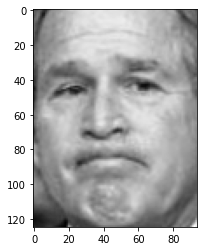

In [31]:
plt.imshow(df.images[0],cmap='gray')
img = df.images[0]
img = tf.expand_dims(img, axis=-1)
img = data_augmentation(img)

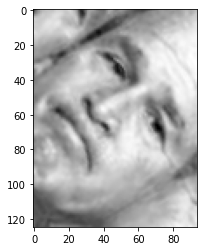

In [32]:
img = np.array(img)
img = np.reshape(img, (125,94))
plt.imshow(img,cmap='gray')


To evaluate our models is better to use in the test set only noraml images already not transformed. In order to do that we have to split the dataset before transforming the train set. This is implemented in the following lines taking the head and the tail of the original dataset with the 70% for train set and 30% for test set.

In [33]:
import copy
train=copy.copy(df)
train.images = df.images[0:797]
train.data = df.data[0:797]
train.target = df.target[0:797]

In [34]:
len(train.images)

797

In [35]:
#import random
test=copy.copy(df)
test.images = test.images[798:1139]
test.data = test.data[798:1139]
test.target = test.target[798:1139]


In [36]:
len(test.images)

341

In the following cells we first implement the two keras tranformation layers on the whole dataset line by line. Then this new tranformed dataset is concatenated to the original one in order to double the number of image in the new one. This is applied twice in order to have at the end a dataset that is four time bigger then the original one.

In [37]:

df2=copy.copy(train)
#df2.images = data_augmentation(df2.images)
j=0
for i in df2.images:
  
  i = tf.expand_dims(i, axis=-1)

  i=data_augmentation(i)
  i=np.array(i)
  i= np.reshape(i, (125,94))
  df2.images[j]=i
  j+=1



Here we also plot an image with his target number to check if the algorithm perform in the right way. 

3


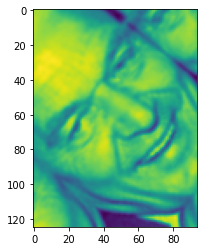

In [38]:
df = fetch_lfw_people(min_faces_per_person=100, color=False,resize=1)
augmented=copy.copy(train)
augmented.images=np.concatenate([train.images, df2.images], 0)
augmented.target=np.concatenate([train.target, df2.target], 0)
plt.imshow(augmented.images[1140])
print(augmented.target[1140])

In [39]:

print(Counter(train.target))
print(Counter(augmented.target))



Counter({2: 372, 0: 170, 1: 93, 4: 88, 3: 74})
Counter({2: 744, 0: 340, 1: 186, 4: 176, 3: 148})


In [40]:
augmented2=augmented
j=0
for i in augmented.images:
  
  i = tf.expand_dims(i, axis=-1)

  i=data_augmentation(i)
  i=np.array(i)
  i= np.reshape(i, (125,94))
  augmented2.images[j]=i
  j+=1

In [41]:
final=copy.copy(augmented)
final.images=np.concatenate([augmented.images, augmented2.images], 0)
final.target=np.concatenate([augmented.target, augmented2.target], 0)

print(final.target[2280])
print(Counter(augmented.target))
print(Counter(final.target))

2
Counter({2: 744, 0: 340, 1: 186, 4: 176, 3: 148})
Counter({2: 1488, 0: 680, 1: 372, 4: 352, 3: 296})


In [42]:
# split into a training and testing set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#X_test=test.images.flatten().reshape(341,11750)
#y_test=test.target

## FEATURE EXTRACTION WITH KERNEL PCA: AUGMENTED DATASET

Here we implement the same kernel PCA we did before but here we tranform the new augmented train set and the new test set.

In [43]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import load_digits
y_train2=final.target
y_test2=test.target
X, _ = load_digits(return_X_y=True)
kpca = KernelPCA(n_components=n_components, kernel='poly', degree=2)
kpca.fit(final.images.flatten().reshape(3188,11750),final.target)
X_train_kpca = kpca.transform(final.images.flatten().reshape(3188,11750)/255)
X_test_kpca = kpca.transform(test.images.flatten().reshape(341,11750)/255)

## SVM WITH KERNEL PCA: AUGMENTED DATASET 


Here we implement the same SVM classifier we used before in order to compare them but with the new train and test set.

In [44]:
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf_a = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm_kpca_a = clf1.fit(X_train_kpca, y_train2)
print("Best estimator found by grid search:")
print(svm_kpca_a.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=100000.0, class_weight='balanced', gamma=0.1)


Train performance and confusion matrix:

In [45]:
y_pred1= svm_kpca_a.predict(X_train_kpca)
print(classification_report(y_train2, y_pred1, target_names=target_names))
print(confusion_matrix(y_train2, y_pred1, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       0.80      0.94      0.86       680
  Donald Rumsfeld       0.82      0.98      0.89       372
    George W Bush       0.98      0.78      0.87      1488
Gerhard Schroeder       0.82      0.99      0.89       296
       Tony Blair       0.85      0.98      0.91       352

         accuracy                           0.88      3188
        macro avg       0.85      0.93      0.88      3188
     weighted avg       0.89      0.88      0.88      3188

[[ 640   10   14    2   14]
 [   4  364    4    0    0]
 [ 150   72 1156   64   46]
 [   2    0    2  292    0]
 [   4    0    4    0  344]]


Test performance and confusion matrix:

In [46]:
y_pred1_test = svm_kpca_a.predict(X_test_kpca)
print(classification_report(y_test2, y_pred1_test, target_names=target_names))
print(confusion_matrix(y_test2, y_pred1_test, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       0.52      0.48      0.50        66
  Donald Rumsfeld       0.26      0.39      0.31        28
    George W Bush       0.66      0.65      0.66       158
Gerhard Schroeder       0.29      0.34      0.31        35
       Tony Blair       0.45      0.33      0.38        54

         accuracy                           0.52       341
        macro avg       0.44      0.44      0.43       341
     weighted avg       0.53      0.52      0.52       341

[[ 32   8  17   4   5]
 [  2  11   9   1   5]
 [ 17  12 103  17   9]
 [  5   4  11  12   3]
 [  5   7  16   8  18]]


## KNN WITH KERNEL PCA: AUGMENTED DATASET

Here we implement the same Nearest Neighbors classifier we used before in order to compare them but with the new train and test set.

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
knn_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])
params = [{'knn__n_neighbors': [5],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [30]}]
nn_kpca_a = GridSearchCV(knn_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
nn_kpca_a.fit(X_train_kpca, y_train2)
nn_kpca_a.best_params_

{'knn__leaf_size': 30, 'knn__n_neighbors': 5, 'knn__weights': 'distance'}

Train performance and cofusion matrix:

In [48]:
y_pred_ed_kpca_train= nn_kpca_a.predict(X_train_kpca)
print(classification_report(y_train2, y_pred_ed_kpca_train, target_names=target_names))
print(confusion_matrix(y_train2, y_pred_ed_kpca_train, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       1.00      1.00      1.00       680
  Donald Rumsfeld       1.00      1.00      1.00       372
    George W Bush       1.00      1.00      1.00      1488
Gerhard Schroeder       1.00      1.00      1.00       296
       Tony Blair       1.00      1.00      1.00       352

         accuracy                           1.00      3188
        macro avg       1.00      1.00      1.00      3188
     weighted avg       1.00      1.00      1.00      3188

[[ 680    0    0    0    0]
 [   0  372    0    0    0]
 [   0    0 1488    0    0]
 [   0    0    0  296    0]
 [   0    0    0    0  352]]


Test performance and cofusion matrix:

In [49]:
y_pred_ed_kpca_test= nn_kpca_a.predict(X_test_kpca)
print(classification_report(y_test2, y_pred_ed_kpca_test, target_names=target_names))
print(confusion_matrix(y_test2, y_pred_ed_kpca_test, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Colin Powell       0.33      0.39      0.36        66
  Donald Rumsfeld       0.17      0.21      0.19        28
    George W Bush       0.55      0.65      0.60       158
Gerhard Schroeder       0.13      0.06      0.08        35
       Tony Blair       0.38      0.17      0.23        54

         accuracy                           0.43       341
        macro avg       0.31      0.30      0.29       341
     weighted avg       0.41      0.43      0.41       341

[[ 26   5  26   4   5]
 [  7   6  15   0   0]
 [ 20  19 103   8   8]
 [ 12   3  16   2   2]
 [ 14   3  27   1   9]]


## CONCLUSIONS

After we implemented the data augmentation the performance of both SVM and Nearest Neighbors classifier didn't improve but they got worst. This is probably because we implemented a type of data augmentation that doesn't fit well with the kernel PCA feature extraction. We choose as the best model the SVM trained and tested with the dataset transformed with the linear PCA reaching an accuracy of 0.89 on the test set, with a polynomial kernel of degree=2, C=5000 and gamma=0.01. Here we plot some images of the test set, their label predicted by our best model and the original label.

The function in the following cell is used to plot the result of the prediction on a portion of the test set.

In [50]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


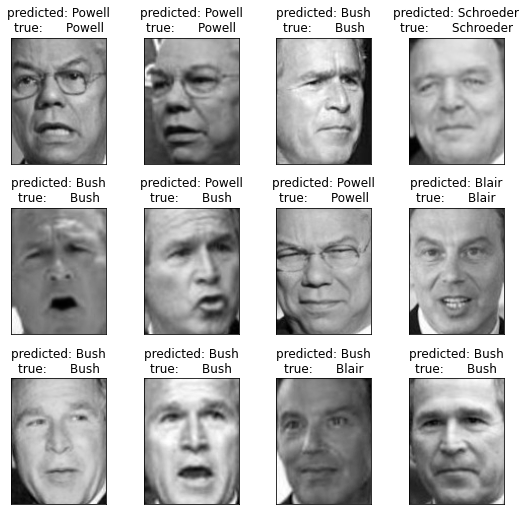

In [52]:
y_pred=svm.predict(X_test_pca)
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

plt.show()